<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_autoenc_codeChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys


## Import and process data

In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# don't need labels! 
data = data[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)


# convert to tensor
dataT = torch.tensor(dataNorm).float()

In [ ]:
dataT.shape[0]

20000

In [ ]:
dataT.size()

torch.Size([20000, 784])

In [ ]:
idx = torch.randperm(dataT.shape[0])
shuffledDataT = dataT[idx]
shuffledDataT.shape

torch.Size([20000, 784])

In [ ]:
dataT[1] - shuffledDataT[1]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [ ]:
batchData = shuffledDataT.view(1000, 20, 784)
batchData.shape

torch.Size([1000, 20, 784])

## Create the DL Model

In [ ]:
# create a class for the model
def createTheMNISTAE(encUnits, latUnits):

    class aenet(nn.Module):
        def __init__(self, encUnits, latUnits):
            super().__init__()

            ## input layer
            self.input = nn.Linear(784, encUnits)

            ## encoder layer
            self.enc = nn.Linear(encUnits, latUnits)

            ## latent layer
            self.lat = nn.Linear(latUnits, encUnits)

            ## decoder layer
            self.dec = nn.Linear(encUnits, 784)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            y = torch.sigmoid(self.dec(x))
            return y

    # create the model instance
    net = aenet(encUnits, latUnits)

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfun, optimizer




In [ ]:
# test the model with a bit of data
net, lossfun, optimizer = createTheMNISTAE(250, 50)

X = batchData[1, :, :]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([20, 784])
torch.Size([20, 784])


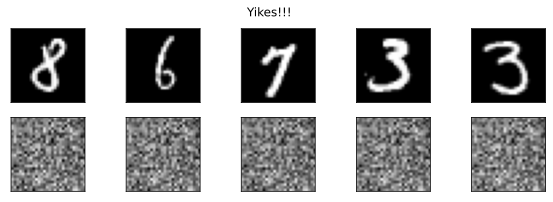

In [ ]:
# let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10,3))

for i in range(5):
    axs[0, i].imshow(X[i,:].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(yHat[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.suptitle('Yikes!!!')
plt.show()

## Create a function taht trains the model

In [ ]:
def function2trainTheModel(encUnits, latUnits):

    # number of epochs
    numepochs = 3

    # create a new model
    net, lossfun, optimizer = createTheMNISTAE(encUnits, latUnits)

    # initialize losses
    losses = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # select a random set of images
        # randomidx = np.random.choice(dataT.shape[0], size=32)
        # X = dataT[randomidx, :]
        batchLoss = []
        # loop over batches
        for i in range(batchData.shape[0]):
            X = batchData[i, :, :]

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, X)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        # losses in this epoch
        losses[epochi] = np.mean(batchLoss)

    # end epochs

    # function output
    return losses, net

## Run the model and show the results

Final loss: 0.0131


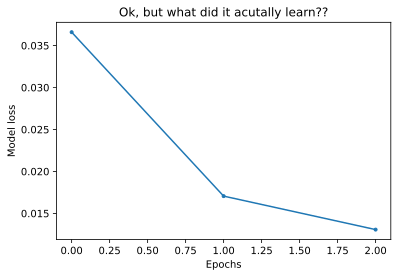

In [ ]:
encUnits = 250
latUnits = 50

# train the model
losses, net = function2trainTheModel(encUnits, latUnits)
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses, '.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Ok, but what did it acutally learn??')
plt.show()

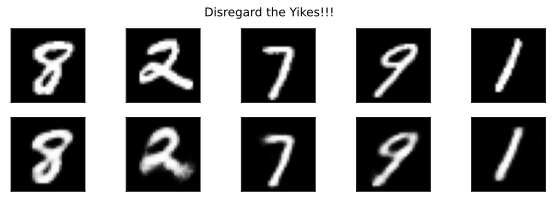

In [ ]:
# repeat the visualization when testing the model
X = batchData[0, :5, :]
yHat = net(X)

# let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10,3))

for i in range(5):
    axs[0, i].imshow(X[i,:].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(yHat[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.suptitle('Disregard the Yikes!!!')
plt.show()

## It's time to experiment

In [ ]:
encUnitsSpace = np.linspace(10, 500, 12).astype('int')
bottleneckUnits = np.linspace(5, 100, 8).astype('int')

all_losses = np.zeros((len(encUnitsSpace), len(bottleneckUnits)))


for (ei, encUnits) in enumerate(encUnitsSpace):

    for (bi, latUnits) in enumerate(bottleneckUnits):

        losses, net = function2trainTheModel(encUnits, latUnits) 

        all_losses[ei, bi] = torch.mean(losses[-3:]).item()

        # send update message
        currentIter = ei * len(bottleneckUnits) + bi + 1
        totalIters = len(bottleneckUnits) * len(encUnitsSpace)
        msg = 'Finished experiment {}/{}'.format(currentIter, totalIters)
        sys.stdout.write('\r' + msg)

Finished experiment 96/96

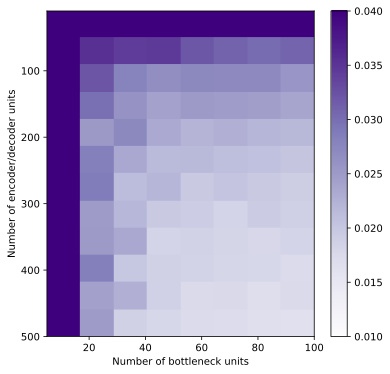

In [ ]:
# show the ressults matrix
fig = plt.figure(figsize=(6, 6))

plt.imshow(all_losses, aspect='auto',
           vmin=.01, vmax=.04, cmap='Purples',
           extent=[bottleneckUnits[0], bottleneckUnits[-1], encUnitsSpace[-1], encUnitsSpace[0]])

plt.xlabel('Number of bottleneck units') 
plt.ylabel('Number of encoder/decoder units') 
plt.colorbar()

plt.show()

## perhaps a line plot will better reveal the sudden transition

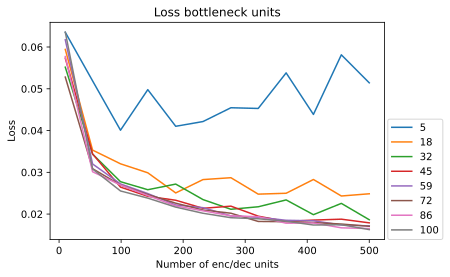

In [ ]:
plt.plot(encUnitsSpace, all_losses)
plt.legend(bottleneckUnits, loc=(1.01, 0))
plt.xlabel('Number of enc/dec units')
plt.title('Loss bottleneck units')
plt.ylabel('Loss')
plt.show()